In [2]:
import pandas as pd

def extract_one_bedroom_rents(input_excel, sheet_name=4):
    """
    Extracts one-bedroom rent data from the specified Excel sheet.
    
    Args:
        input_excel (str): Path to the Excel file.
        sheet_name (int or str): The sheet name or index to load.
    
    Returns:
        DataFrame: Clean DataFrame with borough names and mean rent for one-bedroom properties.
    """
    # Load the sheet, using the correct header row
    data = pd.read_excel(input_excel, sheet_name=sheet_name, header=2)

    # Filter for "One Bedroom" category
    one_bedroom_data = data[data['Bedroom Category'] == 'One Bedroom']

    # Extract relevant columns
    one_bedroom_rents = one_bedroom_data[['Borough', 'Mean']].copy()

    # Rename columns for clarity
    one_bedroom_rents.columns = ['Borough', 'MeanRent']

    # Convert "MeanRent" to numeric, handling missing values
    one_bedroom_rents['MeanRent'] = pd.to_numeric(one_bedroom_rents['MeanRent'], errors='coerce')

    # Drop rows with missing data
    one_bedroom_rents = one_bedroom_rents.dropna()

    # Clean borough names
    one_bedroom_rents['Borough'] = one_bedroom_rents['Borough'].str.title().str.strip()

    return one_bedroom_rents

# Example usage
excel_file = "london_rental_data.xlsx"  # Replace with your file path
sheet_number = 4  # 5th sheet
one_bedroom_rents = extract_one_bedroom_rents(excel_file, sheet_name=sheet_number)

# Display the cleaned data
print(one_bedroom_rents.head())


                 Borough  MeanRent
2   Barking And Dagenham      1158
8                 Barnet      1362
14                Bexley      1148
20                 Brent      1831
26               Bromley      1180


In [3]:

import geopandas as gpd

def check_borough_matching(rent_data, geojson_file):
    """
    Checks if borough names in the rent data match those in the GeoJSON file.

    Args:
        rent_data (DataFrame): DataFrame containing 'Borough' column with rental data.
        geojson_file (str): Path to the GeoJSON file with borough boundaries.
    
    Returns:
        set: Mismatched borough names (if any).
    """
    # Load the GeoJSON file
    london_boroughs_gdf = gpd.read_file(geojson_file)

    # Extract and clean borough names from the GeoJSON file
    geo_boroughs = london_boroughs_gdf['name'].str.title().str.strip()

    # Extract and clean borough names from the rental data
    rent_boroughs = rent_data['Borough'].str.title().str.strip()

    # Compare the sets
    mismatched_boroughs = set(rent_boroughs) - set(geo_boroughs)

    # Print results
    if mismatched_boroughs:
        print("Mismatched Boroughs Found:")
        print(mismatched_boroughs)
    else:
        print("All borough names match!")

    return mismatched_boroughs

# Example usage
geojson_file = "london_boroughs.geojson"  # Replace with your file path
mismatched_boroughs = check_borough_matching(one_bedroom_rents, geojson_file)


All borough names match!


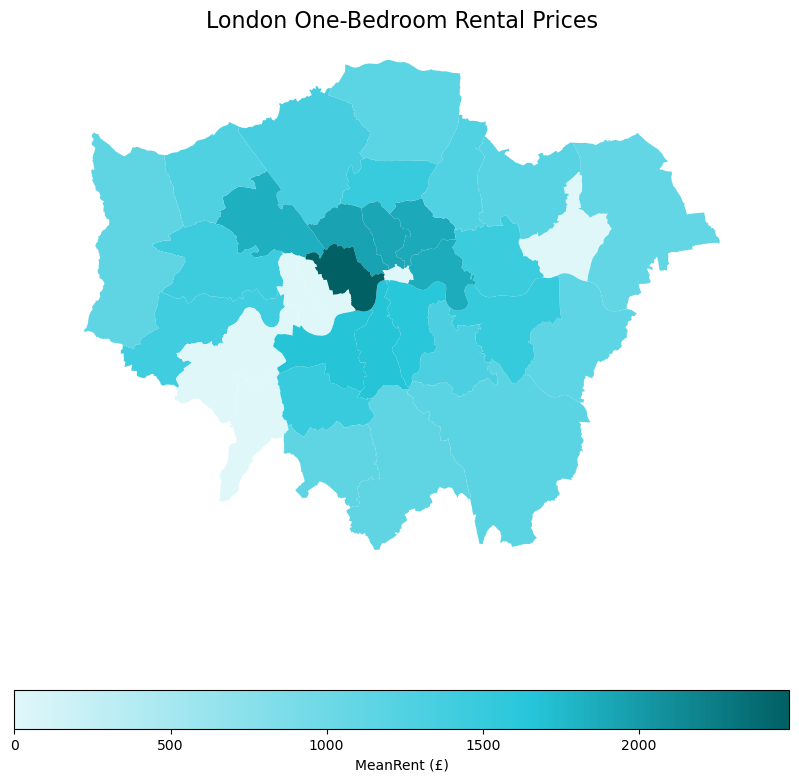

In [4]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def visualize_rent_data(rent_data, geojson_file, rent_column="MeanRent", title="London One-Bedroom Rental Prices"):
    """
    Visualizes rental prices as a choropleth map with the GradStay color scheme.

    Args:
        rent_data (DataFrame): DataFrame with 'Borough' and rent column.
        geojson_file (str): Path to the GeoJSON file with borough boundaries.
        rent_column (str): Column name containing rent data.
        title (str): Title for the map.
    
    Returns:
        None: Displays the map.
    """
    # GradStay color scheme
    gradstay_colors = ["#e0f7fa", "#80deea", "#26c6da", "#006064"]  # Example palette
    
    # Create a custom colormap from the GradStay palette
    cmap = LinearSegmentedColormap.from_list("gradstay", gradstay_colors)

    # Load GeoJSON file
    london_boroughs_gdf = gpd.read_file(geojson_file)

    # Merge GeoJSON with rent data
    merged_gdf = london_boroughs_gdf.merge(rent_data, left_on="name", right_on="Borough", how="left")

    # Handle missing data by filling with 0 or NaN
    merged_gdf[rent_column] = merged_gdf[rent_column].fillna(0)

    # Plot the choropleth map
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    merged_gdf.plot(column=rent_column, cmap=cmap, legend=True, ax=ax,
                    legend_kwds={"label": f"{rent_column} (£)", "orientation": "horizontal"})
    
    # Add a title
    ax.set_title(title, fontsize=16)
    ax.set_axis_off()  # Turn off axes for cleaner visualization

    # Show the plot
    plt.show()

# Example usage
geojson_file = "london_boroughs.geojson"  
visualize_rent_data(one_bedroom_rents, geojson_file)



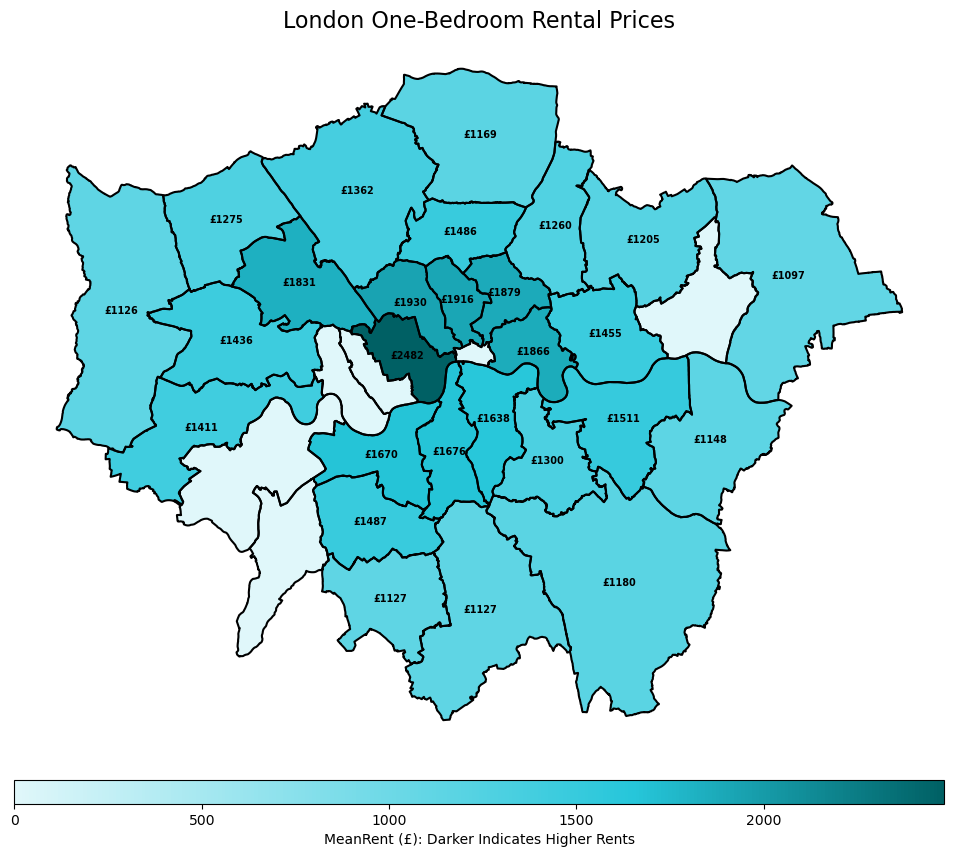

In [5]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import geopandas as gpd
import matplotlib.colorbar as cbar

def visualize_rent_data_with_annotations(rent_data, geojson_file, rent_column="MeanRent", title="London One-Bedroom Rental Prices"):
    """
    Visualizes rental prices as a choropleth map with the GradStay color scheme and displays rent numbers on the map.

    Args:
        rent_data (DataFrame): DataFrame with 'Borough' and rent column.
        geojson_file (str): Path to the GeoJSON file with borough boundaries.
        rent_column (str): Column name containing rent data.
        title (str): Title for the map.
    
    Returns:
        None: Displays the map.
    """
    # GradStay color scheme
    gradstay_colors = ["#e0f7fa", "#80deea", "#26c6da", "#006064"]  # Example palette
    
    # Create a custom colormap from the GradStay palette
    cmap = LinearSegmentedColormap.from_list("gradstay", gradstay_colors)

    # Load GeoJSON file
    london_boroughs_gdf = gpd.read_file(geojson_file)

    # Merge GeoJSON with rent data
    merged_gdf = london_boroughs_gdf.merge(rent_data, left_on="name", right_on="Borough", how="left")

    # Handle missing data by filling with 0
    merged_gdf[rent_column] = merged_gdf[rent_column].fillna(0)

    # Plot the choropleth map
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    merged_gdf.boundary.plot(ax=ax, linewidth=1.5, color="black")  # Plot thicker region borders
    plot = merged_gdf.plot(column=rent_column, cmap=cmap, ax=ax, legend=False)
    
    # Add a title
    ax.set_title(title, fontsize=16)
    ax.set_axis_off()  # Turn off axes for cleaner visualization

    # Create and position the legend (colorbar)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=merged_gdf[rent_column].min(), vmax=merged_gdf[rent_column].max()))
    sm._A = []  # Empty array for ScalarMappable
    cbar = fig.colorbar(sm, ax=ax, orientation="horizontal", pad=0.03, aspect=40)
    cbar.set_label(f"{rent_column} (£): Darker Indicates Higher Rents", fontsize=10)
    
    # Annotate the map with rent values
    for _, row in merged_gdf.iterrows():
        if row.geometry.centroid.is_valid:  # Ensure valid geometries
            centroid = row.geometry.centroid  # Get the centroid of each borough
            rent_value = row[rent_column]  # Get the rent value
            # Annotate only if rent_value is non-zero
            if rent_value > 0:
                ax.annotate(f"£{int(rent_value)}", 
                            xy=(centroid.x, centroid.y),  # Position annotation at the centroid
                            ha="center", va="center", 
                            fontsize=7, color="black", weight="bold")
    
    # Show the plot
    plt.show()

# Example usage
geojson_file = "london_boroughs.geojson"  # Replace with your file path
visualize_rent_data_with_annotations(one_bedroom_rents, geojson_file)


In [6]:
def check_borough_matching(rent_data, geojson_file):
    """
    Checks if borough names in the rent data match those in the GeoJSON file.
    """
    # Load the GeoJSON file
    london_boroughs_gdf = gpd.read_file(geojson_file)
    
    # Get both sets of boroughs
    geo_boroughs = set(london_boroughs_gdf['name'].str.title().str.strip())
    rent_boroughs = set(rent_data['Borough'].str.title().str.strip())
    
    # Find boroughs in rent data but not in GeoJSON
    missing_from_geo = rent_boroughs - geo_boroughs
    
    # Find boroughs in GeoJSON but not in rent data
    missing_from_rent = geo_boroughs - rent_boroughs
    
    print("\nBoroughs in rent data but not in GeoJSON:")
    if missing_from_geo:
        print(missing_from_geo)
    else:
        print("None")
        
    print("\nBoroughs in GeoJSON but not in rent data:")
    if missing_from_rent:
        print(missing_from_rent)
    else:
        print("None")
    
    return missing_from_geo, missing_from_rent

# Example usage
geojson_file = "london_boroughs.geojson"
missing_from_geo, missing_from_rent = check_borough_matching(one_bedroom_rents, geojson_file)


Boroughs in rent data but not in GeoJSON:
None

Boroughs in GeoJSON but not in rent data:
None


In [7]:
# Print all districts in the rental data
print("\nDistricts in rental data:")
print(sorted(one_bedroom_rents['Borough'].tolist()))

# Print all districts in the GeoJSON file
print("\nDistricts in GeoJSON file:")
london_boroughs_gdf = gpd.read_file(geojson_file)
print(sorted(london_boroughs_gdf['name'].tolist()))


Districts in rental data:
['Barking And Dagenham', 'Barnet', 'Bexley', 'Brent', 'Bromley', 'Camden', 'City Of London', 'Croydon', 'Ealing', 'Enfield', 'Greenwich', 'Hackney', 'Hammersmith And Fulham', 'Haringey', 'Harrow', 'Havering', 'Hillingdon', 'Hounslow', 'Islington', 'Kensington And Chelsea', 'Kingston Upon Thames', 'Lambeth', 'Lewisham', 'Merton', 'Newham', 'Redbridge', 'Richmond Upon Thames', 'Southwark', 'Sutton', 'Tower Hamlets', 'Waltham Forest', 'Wandsworth', 'Westminster']

Districts in GeoJSON file:
['Barking and Dagenham', 'Barnet', 'Bexley', 'Brent', 'Bromley', 'Camden', 'City of London', 'Croydon', 'Ealing', 'Enfield', 'Greenwich', 'Hackney', 'Hammersmith and Fulham', 'Haringey', 'Harrow', 'Havering', 'Hillingdon', 'Hounslow', 'Islington', 'Kensington and Chelsea', 'Kingston upon Thames', 'Lambeth', 'Lewisham', 'Merton', 'Newham', 'Redbridge', 'Richmond upon Thames', 'Southwark', 'Sutton', 'Tower Hamlets', 'Waltham Forest', 'Wandsworth', 'Westminster']


In [8]:
# Print exact borough names from both datasets for comparison
print("Rental Data Borough Names:")
print(sorted(one_bedroom_rents['Borough'].tolist()))

print("\nGeoJSON Borough Names:")
london_boroughs_gdf = gpd.read_file(geojson_file)
print(sorted(london_boroughs_gdf['name'].tolist()))

# Let's also check the merge result
merged_gdf = london_boroughs_gdf.merge(one_bedroom_rents, left_on="name", right_on="Borough", how="left")
print("\nBoroughs with missing rental data:")
print(merged_gdf[merged_gdf['MeanRent'].isna()]['name'].tolist())

Rental Data Borough Names:
['Barking And Dagenham', 'Barnet', 'Bexley', 'Brent', 'Bromley', 'Camden', 'City Of London', 'Croydon', 'Ealing', 'Enfield', 'Greenwich', 'Hackney', 'Hammersmith And Fulham', 'Haringey', 'Harrow', 'Havering', 'Hillingdon', 'Hounslow', 'Islington', 'Kensington And Chelsea', 'Kingston Upon Thames', 'Lambeth', 'Lewisham', 'Merton', 'Newham', 'Redbridge', 'Richmond Upon Thames', 'Southwark', 'Sutton', 'Tower Hamlets', 'Waltham Forest', 'Wandsworth', 'Westminster']

GeoJSON Borough Names:
['Barking and Dagenham', 'Barnet', 'Bexley', 'Brent', 'Bromley', 'Camden', 'City of London', 'Croydon', 'Ealing', 'Enfield', 'Greenwich', 'Hackney', 'Hammersmith and Fulham', 'Haringey', 'Harrow', 'Havering', 'Hillingdon', 'Hounslow', 'Islington', 'Kensington and Chelsea', 'Kingston upon Thames', 'Lambeth', 'Lewisham', 'Merton', 'Newham', 'Redbridge', 'Richmond upon Thames', 'Southwark', 'Sutton', 'Tower Hamlets', 'Waltham Forest', 'Wandsworth', 'Westminster']

Boroughs with miss

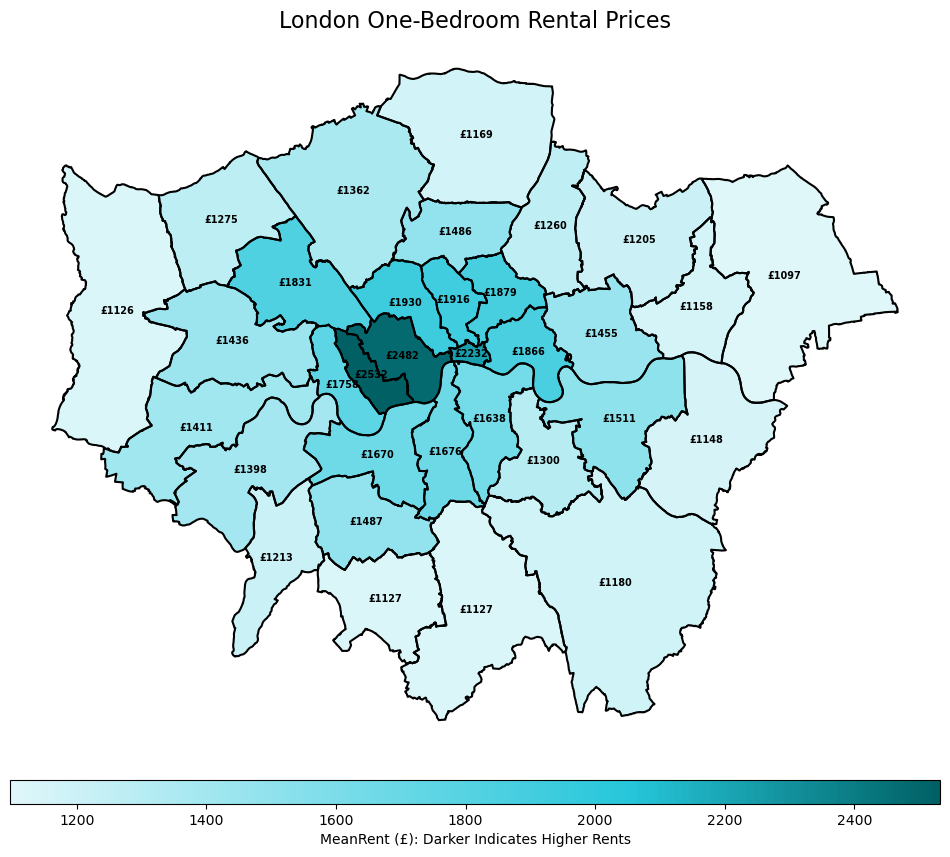

In [9]:
def visualize_rent_data_with_annotations(rent_data, geojson_file, rent_column="MeanRent", title="London One-Bedroom Rental Prices"):
    """
    Visualizes rental prices as a choropleth map with the GradStay color scheme and displays rent numbers on the map.
    """
    # GradStay color scheme
    gradstay_colors = ["#e0f7fa", "#80deea", "#26c6da", "#006064"]
    
    # Create a custom colormap from the GradStay palette
    cmap = LinearSegmentedColormap.from_list("gradstay", gradstay_colors)
    
    # Load GeoJSON file
    london_boroughs_gdf = gpd.read_file(geojson_file)
    
    # Standardize borough names in both datasets
    london_boroughs_gdf['name'] = (london_boroughs_gdf['name']
                                  .str.title()
                                  .str.strip()
                                  .str.replace('-', ' ')
                                  .str.replace('Upon', 'Upon')
                                  .str.replace('And', 'and'))
    
    rent_data = rent_data.copy()
    rent_data['Borough'] = (rent_data['Borough']
                           .str.title()
                           .str.strip()
                           .str.replace('-', ' ')
                           .str.replace('Upon', 'Upon')
                           .str.replace('And', 'and'))

    # Merge GeoJSON with rent data
    merged_gdf = london_boroughs_gdf.merge(rent_data, left_on="name", right_on="Borough", how="left")
    
    # Handle missing data by filling with 0
    merged_gdf[rent_column] = merged_gdf[rent_column].fillna(0)

    # Plot the choropleth map
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    merged_gdf.boundary.plot(ax=ax, linewidth=1.5, color="black")  # Plot thicker region borders
    plot = merged_gdf.plot(column=rent_column, cmap=cmap, ax=ax, legend=False)
    
    # Add a title
    ax.set_title(title, fontsize=16)
    ax.set_axis_off()  # Turn off axes for cleaner visualization

    # Create and position the legend (colorbar)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=merged_gdf[rent_column].min(), vmax=merged_gdf[rent_column].max()))
    sm._A = []  # Empty array for ScalarMappable
    cbar = fig.colorbar(sm, ax=ax, orientation="horizontal", pad=0.03, aspect=40)
    cbar.set_label(f"{rent_column} (£): Darker Indicates Higher Rents", fontsize=10)
    
    # Annotate the map with rent values
    for _, row in merged_gdf.iterrows():
        if row.geometry.centroid.is_valid:  # Ensure valid geometries
            centroid = row.geometry.centroid  # Get the centroid of each borough
            rent_value = row[rent_column]  # Get the rent value
            # Annotate only if rent_value is non-zero
            if rent_value > 0:
                ax.annotate(f"£{int(rent_value)}", 
                            xy=(centroid.x, centroid.y),  # Position annotation at the centroid
                            ha="center", va="center", 
                            fontsize=7, color="black", weight="bold")
    
    # Show the plot
    plt.show()

geojson_file = "london_boroughs.geojson"  # Replace with your file path
visualize_rent_data_with_annotations(one_bedroom_rents, geojson_file)

In [10]:
from IPython.display import HTML

# Add Adobe Typekit CSS
HTML("""
<link rel="stylesheet" href="https://use.typekit.net/jip3qwz.css">
<style>
    .jp-RenderedHTMLCommon {
        font-family: articulat-cf, sans-serif !important;
    }
</style>
""")

In [11]:
from IPython.display import HTML

HTML("""
<link rel="stylesheet" href="https://use.typekit.net/jip3qwz.css">
<style>
    body, div, span {
        font-family: "articulat-cf", sans-serif !important;
    }
    .jp-RenderedHTMLCommon {
        font-family: "articulat-cf", sans-serif !important;
    }
    .CodeMirror {
        font-family: "articulat-cf", monospace !important;
    }
</style>
""")

findfont: Font family 'articulat-cf' not found.
findfont: Font family 'articulat-cf' not found.
findfont: Font family 'articulat-cf' not found.
findfont: Font family 'articulat-cf' not found.
findfont: Font family 'articulat-cf' not found.
findfont: Font family 'articulat-cf' not found.
findfont: Font family 'articulat-cf' not found.
findfont: Font family 'articulat-cf' not found.
findfont: Font family 'articulat-cf' not found.
findfont: Font family 'articulat-cf' not found.
findfont: Font family 'articulat-cf' not found.
findfont: Font family 'articulat-cf' not found.
findfont: Font family 'articulat-cf' not found.
findfont: Font family 'articulat-cf' not found.
findfont: Font family 'articulat-cf' not found.
findfont: Font family 'articulat-cf' not found.
findfont: Font family 'articulat-cf' not found.
findfont: Font family 'articulat-cf' not found.
findfont: Font family 'articulat-cf' not found.
findfont: Font family 'articulat-cf' not found.
findfont: Font family 'articulat-cf' not

NameError: name 'cmap' is not defined

findfont: Font family 'articulat-cf' not found.
findfont: Font family 'articulat-cf' not found.
findfont: Font family 'articulat-cf' not found.
findfont: Font family 'articulat-cf' not found.
findfont: Font family 'articulat-cf' not found.
findfont: Font family 'articulat-cf' not found.
findfont: Font family 'articulat-cf' not found.
findfont: Font family 'articulat-cf' not found.
findfont: Font family 'articulat-cf' not found.
findfont: Font family 'articulat-cf' not found.
findfont: Font family 'articulat-cf' not found.
findfont: Font family 'articulat-cf' not found.
findfont: Font family 'articulat-cf' not found.
findfont: Font family 'articulat-cf' not found.
findfont: Font family 'articulat-cf' not found.
findfont: Font family 'articulat-cf' not found.
findfont: Font family 'articulat-cf' not found.
findfont: Font family 'articulat-cf' not found.
findfont: Font family 'articulat-cf' not found.
findfont: Font family 'articulat-cf' not found.
findfont: Font family 'articulat-cf' not

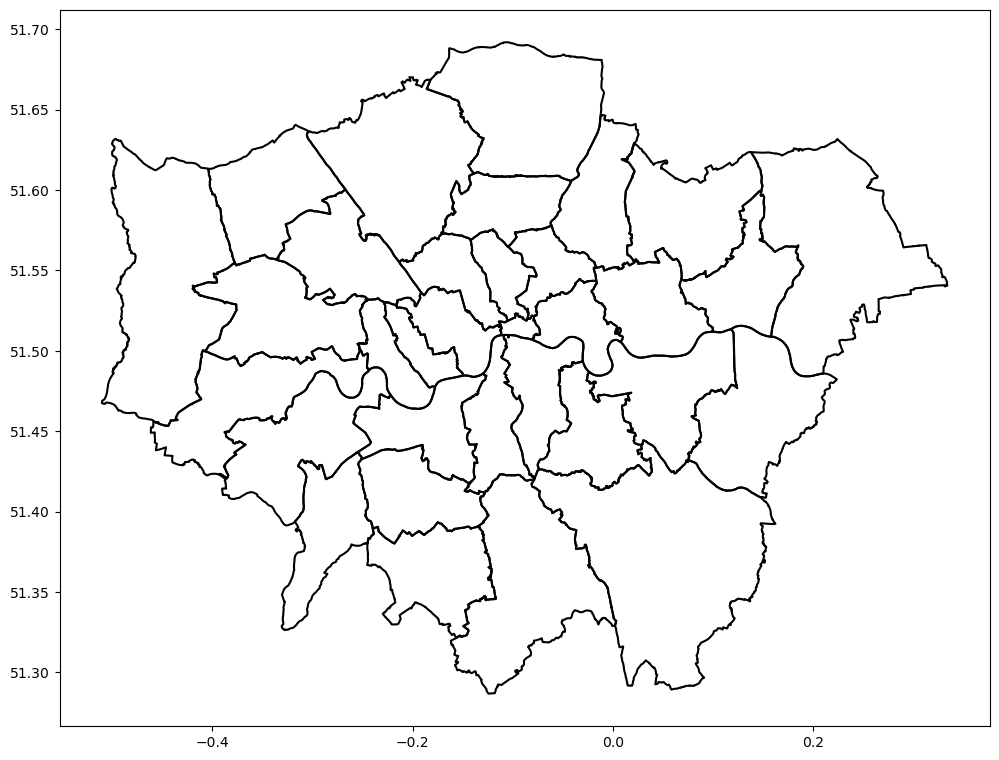

In [12]:
def visualize_rent_data_with_annotations(rent_data, geojson_file, rent_column="MeanRent", title="London One-Bedroom Rental Prices"):
    """
    Visualizes rental prices as a choropleth map with the GradStay color scheme and displays rent numbers on the map.
    """
    # Set the font family for the entire plot
    plt.rcParams['font.family'] = 'articulat-cf'
    
    # ... existing color scheme and data loading code ...
    
    # Plot the choropleth map
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    merged_gdf.boundary.plot(ax=ax, linewidth=1.5, color="black")
    plot = merged_gdf.plot(column=rent_column, cmap=cmap, ax=ax, legend=False)
    
    # Add a title with the custom font
    ax.set_title(title, fontsize=16, fontfamily='articulat-cf', fontweight='bold')
    ax.set_axis_off()

    # Create and position the legend with the custom font
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=merged_gdf[rent_column].min(), 
                                                            vmax=merged_gdf[rent_column].max()))
    sm._A = []
    cbar = fig.colorbar(sm, ax=ax, orientation="horizontal", pad=0.03, aspect=40)
    cbar.set_label(f"{rent_column} (£): Darker Indicates Higher Rents", 
                   fontsize=10, 
                   fontfamily='articulat-cf')
    
    # Annotate with the custom font
    for _, row in merged_gdf.iterrows():
        if row.geometry.centroid.is_valid:
            centroid = row.geometry.centroid
            rent_value = row[rent_column]
            if rent_value > 0:
                ax.annotate(f"£{int(rent_value)}", 
                          xy=(centroid.x, centroid.y),
                          ha="center", 
                          va="center",
                          fontsize=7,
                          color="black",
                          weight="bold",
                          fontfamily='articulat-cf')
    
    plt.show()

geojson_file = "london_boroughs.geojson"  # Replace with your file path
visualize_rent_data_with_annotations(one_bedroom_rents, geojson_file)

In [21]:
import matplotlib.font_manager as fm

# List available fonts
available_fonts = sorted([f.name for f in fm.fontManager.ttflist])
print("Available system fonts that might work well:")
for font in available_fonts:
    if any(name in font.lower() for name in ['helvetica', 'arial', 'sf', 'segoe']):
        print(font)

Available system fonts that might work well:
.SF Arabic
.SF Arabic Rounded
.SF Armenian
.SF Armenian Rounded
.SF Camera
.SF Compact
.SF Compact
.SF Compact Rounded
.SF Georgian
.SF Georgian Rounded
.SF Hebrew
.SF Hebrew Rounded
.SF NS Mono
.SF NS Mono
.SF NS Rounded
.SF Soft Numeric
Arial
Arial
Arial
Arial
Arial Black
Arial Hebrew
Arial Narrow
Arial Narrow
Arial Narrow
Arial Narrow
Arial Rounded MT Bold
Arial Unicode MS
Arial Unicode MS
Helvetica
Helvetica Neue


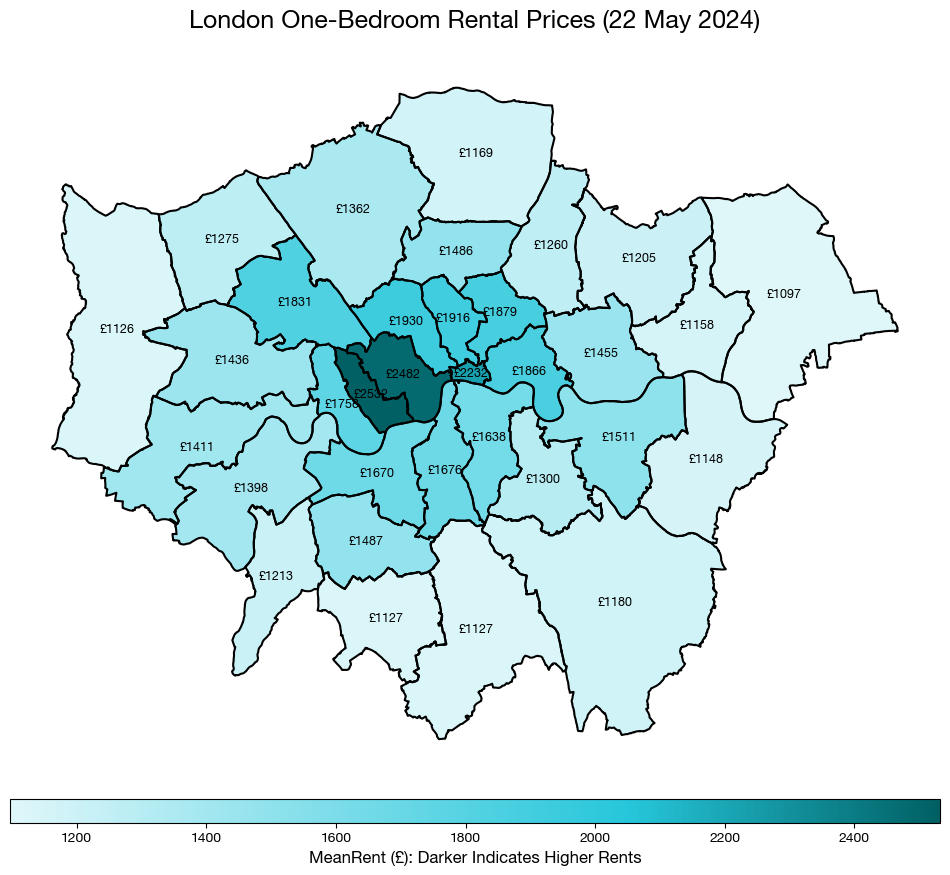

In [24]:
def visualize_rent_data_with_annotations(rent_data, geojson_file, rent_column="MeanRent", title="London One-Bedroom Rental Prices (22 May 2024)"):
    """
    Visualizes rental prices as a choropleth map with the GradStay color scheme and displays rent numbers on the map.
    """
    # Set global font settings
    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': ['Helvetica Neue', 'Helvetica', 'Arial'],
        'font.weight': 'normal',
        'axes.titleweight': 'bold',
        'axes.labelweight': 'bold'
    })
    
    # GradStay color scheme
    gradstay_colors = ["#e0f7fa", "#80deea", "#26c6da", "#006064"]
    cmap = LinearSegmentedColormap.from_list("gradstay", gradstay_colors)
    
    # Load and prepare data
    london_boroughs_gdf = gpd.read_file(geojson_file)
    
    # Standardize borough names
    london_boroughs_gdf['name'] = (london_boroughs_gdf['name']
                                  .str.title()
                                  .str.strip()
                                  .str.replace('-', ' ')
                                  .str.replace('Upon', 'Upon')
                                  .str.replace('And', 'and'))
    
    rent_data = rent_data.copy()
    rent_data['Borough'] = (rent_data['Borough']
                           .str.title()
                           .str.strip()
                           .str.replace('-', ' ')
                           .str.replace('Upon', 'Upon')
                           .str.replace('And', 'and'))

    # Merge data
    merged_gdf = london_boroughs_gdf.merge(rent_data, left_on="name", right_on="Borough", how="left")
    merged_gdf[rent_column] = merged_gdf[rent_column].fillna(0)

    # Create plot
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    
    # Plot borders and fill
    merged_gdf.boundary.plot(ax=ax, linewidth=1.5, color="black")
    merged_gdf.plot(column=rent_column, cmap=cmap, ax=ax, legend=False)
    
    # Style title with consistent font
    ax.set_title(title, 
                fontsize=18, 
                pad=20, 
                weight='bold', 
                family='Helvetica Neue')
    ax.set_axis_off()

    # Add and style colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, 
                              norm=plt.Normalize(vmin=merged_gdf[rent_column].min(), 
                                               vmax=merged_gdf[rent_column].max()))
    sm._A = []
    cbar = fig.colorbar(sm, ax=ax, orientation="horizontal", pad=0.03, aspect=40)
    cbar.set_label(f"{rent_column} (£): Darker Indicates Higher Rents", 
                   fontsize=12, 
                   weight='bold', 
                   family='Helvetica Neue')
    
    # Style colorbar ticks
    cbar.ax.tick_params(labelsize=10)
    for label in cbar.ax.get_xticklabels():
        label.set_family('Helvetica Neue')
    
    # Add annotations with bold values
    for _, row in merged_gdf.iterrows():
        if row.geometry.centroid.is_valid:
            centroid = row.geometry.centroid
            rent_value = row[rent_column]
            if rent_value > 0:
                ax.annotate(f"£{int(rent_value)}", 
                          xy=(centroid.x, centroid.y),
                          ha="center", 
                          va="center",
                          fontsize=9,  # Increased size for better readability
                          color="black",
                          weight='bold',
                          family='Helvetica Neue')
    
    plt.show()

# Run the visualization
geojson_file = "london_boroughs.geojson"
visualize_rent_data_with_annotations(one_bedroom_rents, geojson_file)

/var/folders/30/6x4xwhlx65q539cppr85k0h00000gn/T/ipykernel_89251/891175104.py:77: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged_gdf['area'] = merged_gdf.geometry.area


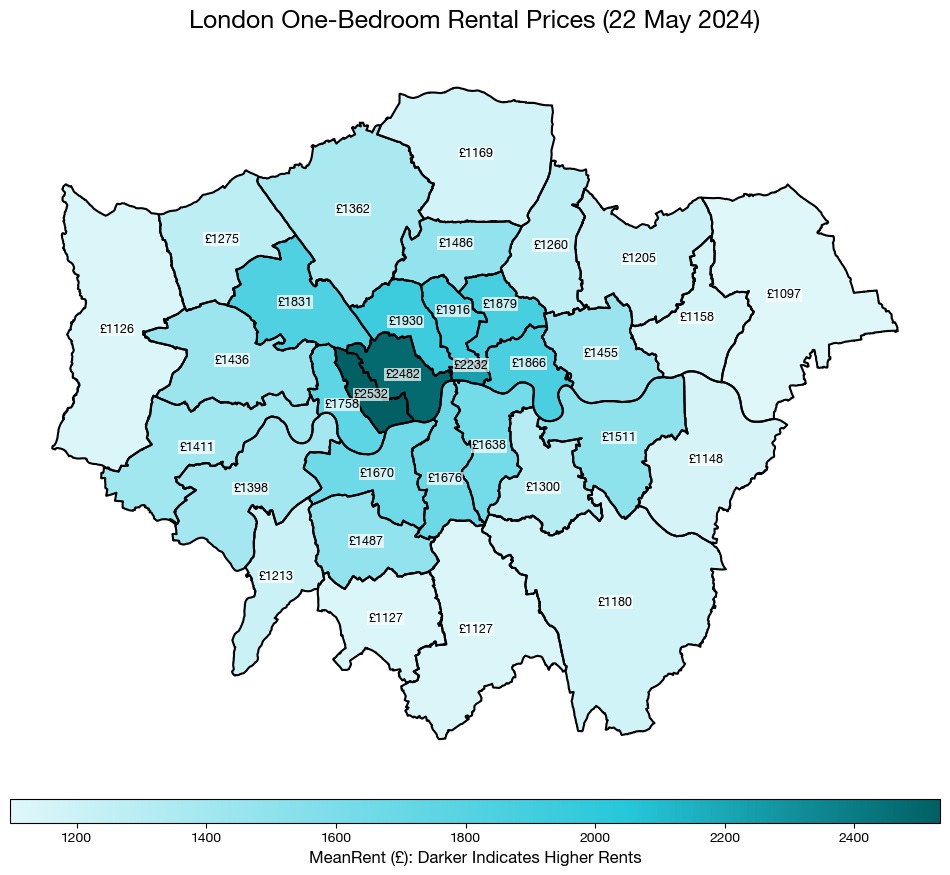

In [28]:
def visualize_rent_data_with_annotations1(rent_data, geojson_file, rent_column="MeanRent", 
                                       title="London One-Bedroom Rental Prices (22 May 2024)"):
    """
    Visualizes rental prices as a choropleth map with the GradStay color scheme and displays rent numbers on the map.
    """
    # Set global font settings
    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': ['Helvetica Neue', 'Helvetica', 'Arial'],
        'font.weight': 'normal',
        'axes.titleweight': 'bold',
        'axes.labelweight': 'bold'
    })
    
    # GradStay color scheme
    gradstay_colors = ["#e0f7fa", "#80deea", "#26c6da", "#006064"]
    cmap = LinearSegmentedColormap.from_list("gradstay", gradstay_colors)
    
    # Load and prepare data
    london_boroughs_gdf = gpd.read_file(geojson_file)
    
    # Standardize borough names
    london_boroughs_gdf['name'] = (london_boroughs_gdf['name']
                                  .str.title()
                                  .str.strip()
                                  .str.replace('-', ' ')
                                  .str.replace('Upon', 'Upon')
                                  .str.replace('And', 'and'))
    
    rent_data = rent_data.copy()
    rent_data['Borough'] = (rent_data['Borough']
                           .str.title()
                           .str.strip()
                           .str.replace('-', ' ')
                           .str.replace('Upon', 'Upon')
                           .str.replace('And', 'and'))

    # Merge data
    merged_gdf = london_boroughs_gdf.merge(rent_data, left_on="name", right_on="Borough", how="left")
    merged_gdf[rent_column] = merged_gdf[rent_column].fillna(0)

    # Create plot
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    
    # Plot borders and fill
    merged_gdf.boundary.plot(ax=ax, linewidth=1.5, color="black")
    merged_gdf.plot(column=rent_column, cmap=cmap, ax=ax, legend=False)
    
    # Style title with consistent font
    ax.set_title(title, 
                fontsize=18, 
                pad=20, 
                weight='bold', 
                family='Helvetica Neue')
    ax.set_axis_off()

    # Add and style colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, 
                              norm=plt.Normalize(vmin=merged_gdf[rent_column].min(), 
                                               vmax=merged_gdf[rent_column].max()))
    sm._A = []
    cbar = fig.colorbar(sm, ax=ax, orientation="horizontal", pad=0.03, aspect=40)
    cbar.set_label(f"{rent_column} (£): Darker Indicates Higher Rents", 
                   fontsize=12, 
                   weight='bold', 
                   family='Helvetica Neue')
    
    # Style colorbar ticks
    cbar.ax.tick_params(labelsize=10)
    for label in cbar.ax.get_xticklabels():
        label.set_family('Helvetica Neue')
    
    # Create a list to store annotation positions for overlap checking
    used_positions = []
    
    # Sort boroughs by size (smallest first) to prioritize their label placement
    merged_gdf['area'] = merged_gdf.geometry.area
    sorted_data = merged_gdf.sort_values('area', ascending=True)

    # Add annotations with overlap avoidance
    for _, row in sorted_data.iterrows():
        if row.geometry.centroid.is_valid:
            centroid = row.geometry.centroid
            rent_value = row[rent_column]
            if rent_value > 0:
                x, y = centroid.x, centroid.y
                
                # Adjust position for small central boroughs
                if row['area'] < merged_gdf['area'].median():
                    # Check if this is a central borough (you might need to adjust these coordinates)
                    if -0.15 < x < 0.15:  # Approximate central London x-coordinates
                        # Offset the label slightly based on position
                        if y > 51.5:  # North of center
                            y += 0.005
                        else:  # South of center
                            y -= 0.005
                
                ax.annotate(f"£{int(rent_value)}", 
                          xy=(x, y),
                          ha="center", 
                          va="center",
                          fontsize=9,
                          color="black",
                          weight='bold',
                          family='Helvetica Neue',
                          bbox=dict(facecolor='white', 
                                  edgecolor='none',
                                  alpha=0.7,
                                  pad=0.5))
    
    plt.show()

# Run the visualization
geojson_file = "london_boroughs.geojson"
visualize_rent_data_with_annotations1(one_bedroom_rents, geojson_file)

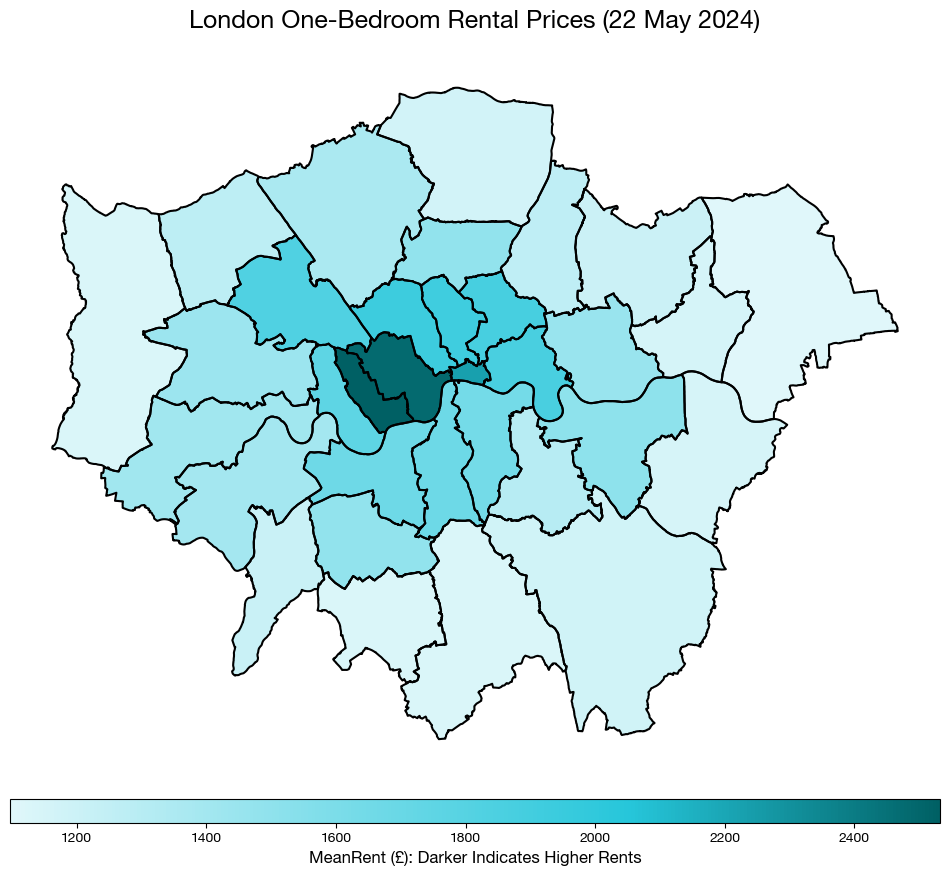

In [27]:
def visualize_rent_data_no_annotations2(rent_data, geojson_file, rent_column="MeanRent", 
                                       title="London One-Bedroom Rental Prices (22 May 2024)"):
    """
    Visualizes rental prices as a choropleth map with the GradStay color scheme.
    """
    # Set global font settings
    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': ['Helvetica Neue', 'Helvetica', 'Arial'],
        'font.weight': 'normal',
        'axes.titleweight': 'bold',
        'axes.labelweight': 'bold'
    })
    
    # GradStay color scheme
    gradstay_colors = ["#e0f7fa", "#80deea", "#26c6da", "#006064"]
    cmap = LinearSegmentedColormap.from_list("gradstay", gradstay_colors)
    
    # Load and prepare data
    london_boroughs_gdf = gpd.read_file(geojson_file)
    
    # Standardize borough names
    london_boroughs_gdf['name'] = (london_boroughs_gdf['name']
                                  .str.title()
                                  .str.strip()
                                  .str.replace('-', ' ')
                                  .str.replace('Upon', 'Upon')
                                  .str.replace('And', 'and'))
    
    rent_data = rent_data.copy()
    rent_data['Borough'] = (rent_data['Borough']
                           .str.title()
                           .str.strip()
                           .str.replace('-', ' ')
                           .str.replace('Upon', 'Upon')
                           .str.replace('And', 'and'))

    # Merge data
    merged_gdf = london_boroughs_gdf.merge(rent_data, left_on="name", right_on="Borough", how="left")
    merged_gdf[rent_column] = merged_gdf[rent_column].fillna(0)

    # Create plot
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    
    # Plot borders and fill
    merged_gdf.boundary.plot(ax=ax, linewidth=1.5, color="black")
    merged_gdf.plot(column=rent_column, cmap=cmap, ax=ax, legend=False)
    
    # Style title with consistent font
    ax.set_title(title, 
                fontsize=18, 
                pad=20, 
                weight='bold', 
                family='Helvetica Neue')
    ax.set_axis_off()

    # Add and style colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, 
                              norm=plt.Normalize(vmin=merged_gdf[rent_column].min(), 
                                               vmax=merged_gdf[rent_column].max()))
    sm._A = []
    cbar = fig.colorbar(sm, ax=ax, orientation="horizontal", pad=0.03, aspect=40)
    cbar.set_label(f"{rent_column} (£): Darker Indicates Higher Rents", 
                   fontsize=12, 
                   weight='bold', 
                   family='Helvetica Neue')
    
    # Style colorbar ticks
    cbar.ax.tick_params(labelsize=10)
    for label in cbar.ax.get_xticklabels():
        label.set_family('Helvetica Neue')
    
    plt.show()

# Run the visualization
geojson_file = "london_boroughs.geojson"
visualize_rent_data_no_annotations2(one_bedroom_rents, geojson_file)

/var/folders/30/6x4xwhlx65q539cppr85k0h00000gn/T/ipykernel_2810/501132975.py:76: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels([f'£{int(x):,}' for x in cbar.get_ticks()])


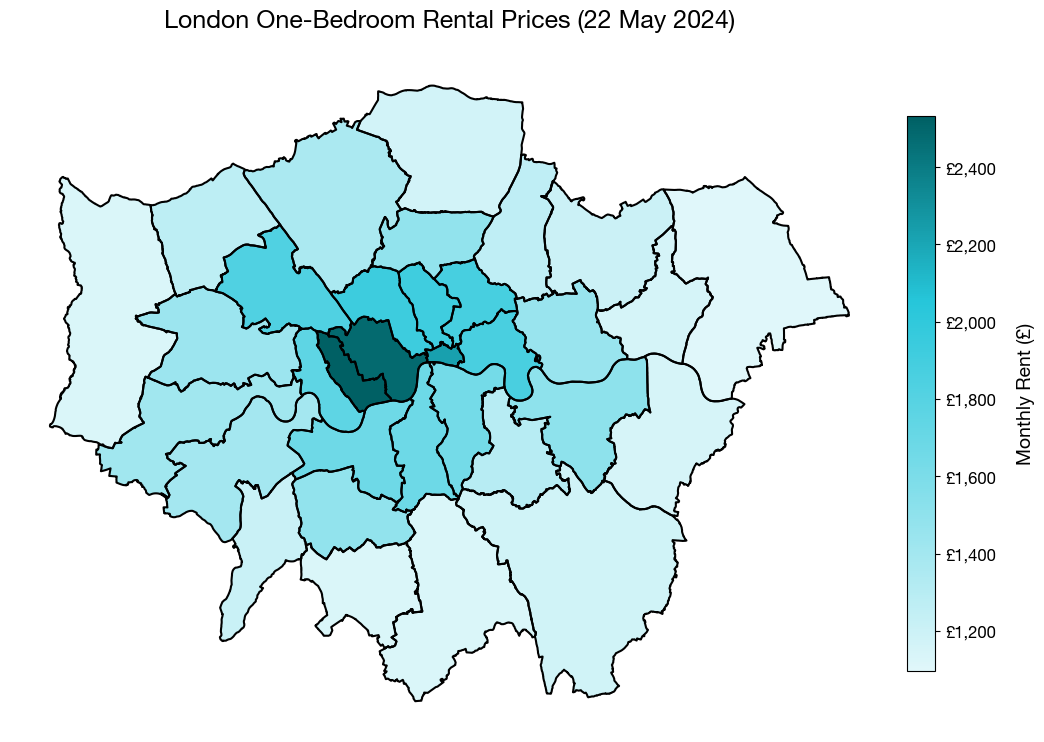

In [16]:
def visualize_rent_data_no_annotations(rent_data, geojson_file, rent_column="MeanRent", 
                                       title="London One-Bedroom Rental Prices (22 May 2024)"):
    """
    Visualizes rental prices as a choropleth map with the GradStay color scheme.
    """
    # Set global font settings
    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': ['Helvetica Neue', 'Helvetica', 'Arial'],
        'font.weight': 'normal',
        'axes.titleweight': 'bold',
        'axes.labelweight': 'bold'
    })
    
    # GradStay color scheme
    gradstay_colors = ["#e0f7fa", "#80deea", "#26c6da", "#006064"]
    cmap = LinearSegmentedColormap.from_list("gradstay", gradstay_colors)
    
    # Load and prepare data
    london_boroughs_gdf = gpd.read_file(geojson_file)
    
    # Standardize borough names
    london_boroughs_gdf['name'] = (london_boroughs_gdf['name']
                                  .str.title()
                                  .str.strip()
                                  .str.replace('-', ' ')
                                  .str.replace('Upon', 'Upon')
                                  .str.replace('And', 'and'))
    
    rent_data = rent_data.copy()
    rent_data['Borough'] = (rent_data['Borough']
                           .str.title()
                           .str.strip()
                           .str.replace('-', ' ')
                           .str.replace('Upon', 'Upon')
                           .str.replace('And', 'and'))

    # Merge data
    merged_gdf = london_boroughs_gdf.merge(rent_data, left_on="name", right_on="Borough", how="left")
    merged_gdf[rent_column] = merged_gdf[rent_column].fillna(0)

    # Create plot
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    
    # Plot borders and fill
    merged_gdf.boundary.plot(ax=ax, linewidth=1.5, color="black")
    merged_gdf.plot(column=rent_column, cmap=cmap, ax=ax, legend=False)
    
    # Style title with consistent font
    ax.set_title(title, 
                fontsize=18, 
                pad=20, 
                weight='bold', 
                family='Helvetica Neue')
    ax.set_axis_off()

    # Add and style colorbar on the right with adjusted position
    sm = plt.cm.ScalarMappable(cmap=cmap, 
                              norm=plt.Normalize(vmin=merged_gdf[rent_column].min(), 
                                               vmax=merged_gdf[rent_column].max()))
    sm._A = []
    cbar = fig.colorbar(sm, ax=ax, orientation="vertical", 
                       pad=0.02,
                       fraction=0.035,  # Make the colorbar even thinner
                       shrink=0.6)      # Make the colorbar even shorter
    cbar.set_label("Monthly Rent (£)", 
                   fontsize=14,         # Increased font size
                   weight='bold', 
                   family='Helvetica Neue',
                   labelpad=15)
    
    # Style colorbar ticks
    cbar.ax.tick_params(labelsize=12, rotation=0)  # Horizontal labels with increased size
    
    # Add pound signs to tick labels
    cbar.ax.set_yticklabels([f'£{int(x):,}' for x in cbar.get_ticks()])
    
    # Apply font to tick labels
    for label in cbar.ax.get_yticklabels():
        label.set_family('Helvetica Neue')
    
    plt.show()

# Run the visualization
geojson_file = "london_boroughs.geojson"
visualize_rent_data_no_annotations(one_bedroom_rents, geojson_file)